In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Fetching Data

In [2]:
train = pd.read_csv("../data/data_train.csv")
test = pd.read_csv("../data/data_test.csv")

In [3]:
X = train.drop(columns = ['SalePrice'])
y = train['SalePrice']

In [4]:
from sklearn.metrics import mean_absolute_error
X_test = test.drop(columns = ['SalePrice'])
y_test = test['SalePrice']

### Helper function - Compute summary vectors

In [5]:
#Function to calculate a vector of mean and standard deviation values for each paramter

def compute_vectors(grid_search, trials):
    '''
    Takes a grid_search object and the number of trials as input
    '''
    mean_vec = np.zeros(trials)
    std_vec = np.zeros(trials)
    i = 0
    
    #Using Grid Search's 'cv_results' attribute to get mean and std for each paramter
    for mean_score, std_score in zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["std_test_score"]):
        mean_vec[i] = -mean_score
        # negative sign used with mean.score() to get positive mean squared error
        std_vec[i] = std_score
        i = i+1

    return mean_vec, std_vec

# SVR

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

svr_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])
param_grid = {'svr__C': [0.1, 1],
              'svr__kernel': ['linear','poly', 'rbf', 'sigmoid']
             }

svr_model = GridSearchCV(svr_pipe, param_grid, cv = 5, scoring = 'neg_mean_absolute_error', verbose = 4)
svr_model.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END svr__C=0.1, svr__kernel=linear;, score=-54264.425 total time=   0.4s
[CV 2/5] END svr__C=0.1, svr__kernel=linear;, score=-55885.476 total time=   0.4s
[CV 3/5] END svr__C=0.1, svr__kernel=linear;, score=-60450.946 total time=   0.4s
[CV 4/5] END svr__C=0.1, svr__kernel=linear;, score=-55936.386 total time=   0.4s
[CV 5/5] END svr__C=0.1, svr__kernel=linear;, score=-46899.708 total time=   0.4s
[CV 1/5] END .svr__C=0.1, svr__kernel=poly;, score=-55202.949 total time=   0.4s
[CV 2/5] END .svr__C=0.1, svr__kernel=poly;, score=-56775.717 total time=   0.4s
[CV 3/5] END .svr__C=0.1, svr__kernel=poly;, score=-61439.270 total time=   0.4s
[CV 4/5] END .svr__C=0.1, svr__kernel=poly;, score=-56800.151 total time=   0.4s
[CV 5/5] END .svr__C=0.1, svr__kernel=poly;, score=-47696.715 total time=   0.4s
[CV 1/5] END ..svr__C=0.1, svr__kernel=rbf;, score=-55201.669 total time=   0.5s
[CV 2/5] END ..svr__C=0.1, svr__kernel=rbf;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_absolute_error', verbose=4)

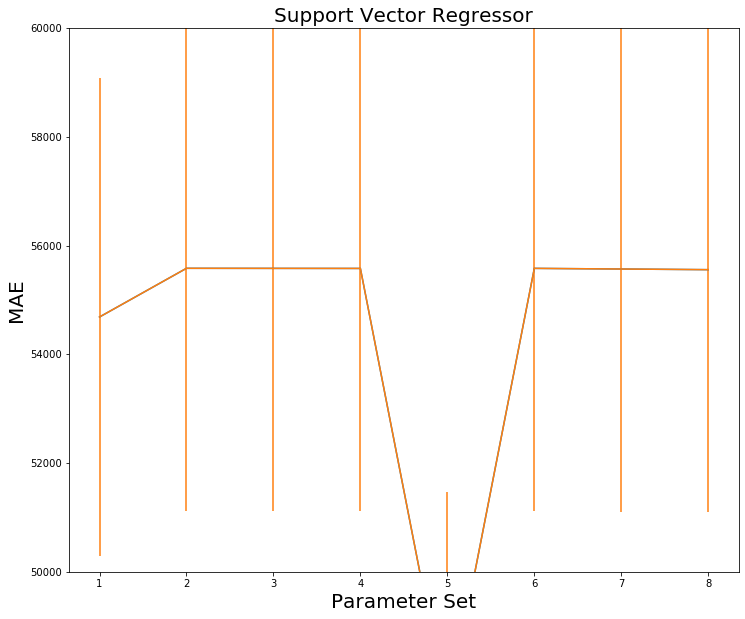

In [87]:
iterations = 8
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(svr_model, iterations)

plt.figure(figsize=(12,10))
plt.title('Support Vector Regressor', fontsize= 20)
plt.plot((np.arange(iterations)+1), mean_vec)
plt.errorbar((np.arange(iterations)+1), mean_vec, yerr = std_vec)
plt.ylabel("MAE", fontsize= 20)
plt.xlabel("Parameter Set", fontsize= 20)
plt.ylim(50000, 60000)
plt.show()

In [88]:
#print vals
svr_results = pd.DataFrame(svr_model.cv_results_)
svr_results = svr_results[['params','mean_test_score','std_test_score', 'rank_test_score']]
svr_results = svr_results.sort_values(by=['rank_test_score'])
svr_results.head(10)

,params,mean_test_score,std_test_score,rank_test_score
4,"{'svr__C': 1, 'svr__kernel': 'linear'}",-47407.731892,4053.617840,1
0,"{'svr__C': 0.1, 'svr__kernel': 'linear'}",-54687.388136,4405.470834,2
7,"{'svr__C': 1, 'svr__kernel': 'sigmoid'}",-55558.096779,4460.408936,3
6,"{'svr__C': 1, 'svr__kernel': 'rbf'}",-55569.984381,4461.907478,4
3,"{'svr__C': 0.1, 'svr__kernel': 'sigmoid'}",-55580.578305,4461.611279,5
2,"{'svr__C': 0.1, 'svr__kernel': 'rbf'}",-55581.767023,4461.761212,6
5,"{'svr__C': 1, 'svr__kernel': 'poly'}",-55581.916120,4462.198685,7
1,"{'svr__C': 0.1, 'svr__kernel': 'poly'}",-55582.960316,4461.790120,8


In [95]:
# Test set valuation
svr_best = Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C = 1, kernel = 'linear'))])
print('Best SVR parameters: ', svr_model.best_params_)

svr_best.fit(X, y)
y_pred = svr_best.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))

Best SVR parameters:  {'svr__C': 1, 'svr__kernel': 'linear'}
MAE : 45744.905265780915


# Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, random_state=0, criterion = 'mae')

param_grid = {
    'ccp_alpha': [0.001, 0.01, 0.1, 1, 10],
    'n_estimators':[10, 100, 500],
    'max_features': ('auto', 'sqrt', 'log2')
}

rf_model = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_absolute_error', verbose=4)
rf_model.fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END ccp_alpha=0.001, max_features=auto, n_estimators=10;, score=-17361.544 total time=   2.1s
[CV 2/5] END ccp_alpha=0.001, max_features=auto, n_estimators=10;, score=-21794.435 total time=   1.4s
[CV 3/5] END ccp_alpha=0.001, max_features=auto, n_estimators=10;, score=-18524.748 total time=   0.8s
[CV 4/5] END ccp_alpha=0.001, max_features=auto, n_estimators=10;, score=-20419.634 total time=   0.8s
[CV 5/5] END ccp_alpha=0.001, max_features=auto, n_estimators=10;, score=-17055.696 total time=   0.9s
[CV 1/5] END ccp_alpha=0.001, max_features=auto, n_estimators=100;, score=-16332.764 total time=   4.9s
[CV 2/5] END ccp_alpha=0.001, max_features=auto, n_estimators=100;, score=-20164.580 total time=   4.9s
[CV 3/5] END ccp_alpha=0.001, max_features=auto, n_estimators=100;, score=-17323.292 total time=   4.9s
[CV 4/5] END ccp_alpha=0.001, max_features=auto, n_estimators=100;, score=-19786.733 total time=   4.9s
[CV 5/5

[CV 1/5] END ccp_alpha=0.01, max_features=log2, n_estimators=100;, score=-17126.143 total time=   0.4s
[CV 2/5] END ccp_alpha=0.01, max_features=log2, n_estimators=100;, score=-21337.732 total time=   0.4s
[CV 3/5] END ccp_alpha=0.01, max_features=log2, n_estimators=100;, score=-20254.403 total time=   0.4s
[CV 4/5] END ccp_alpha=0.01, max_features=log2, n_estimators=100;, score=-20244.353 total time=   0.5s
[CV 5/5] END ccp_alpha=0.01, max_features=log2, n_estimators=100;, score=-16971.187 total time=   0.4s
[CV 1/5] END ccp_alpha=0.01, max_features=log2, n_estimators=500;, score=-17273.722 total time=   1.5s
[CV 2/5] END ccp_alpha=0.01, max_features=log2, n_estimators=500;, score=-20606.787 total time=   1.5s
[CV 3/5] END ccp_alpha=0.01, max_features=log2, n_estimators=500;, score=-19693.394 total time=   1.5s
[CV 4/5] END ccp_alpha=0.01, max_features=log2, n_estimators=500;, score=-20072.965 total time=   1.5s
[CV 5/5] END ccp_alpha=0.01, max_features=log2, n_estimators=500;, score=

[CV 2/5] END ccp_alpha=1, max_features=sqrt, n_estimators=500;, score=-19448.260 total time=   2.2s
[CV 3/5] END ccp_alpha=1, max_features=sqrt, n_estimators=500;, score=-17589.618 total time=   2.2s
[CV 4/5] END ccp_alpha=1, max_features=sqrt, n_estimators=500;, score=-18557.900 total time=   2.2s
[CV 5/5] END ccp_alpha=1, max_features=sqrt, n_estimators=500;, score=-15352.812 total time=   2.1s
[CV 1/5] END ccp_alpha=1, max_features=log2, n_estimators=10;, score=-20292.293 total time=   0.2s
[CV 2/5] END ccp_alpha=1, max_features=log2, n_estimators=10;, score=-24191.461 total time=   0.2s
[CV 3/5] END ccp_alpha=1, max_features=log2, n_estimators=10;, score=-23587.861 total time=   0.2s
[CV 4/5] END ccp_alpha=1, max_features=log2, n_estimators=10;, score=-24380.156 total time=   0.2s
[CV 5/5] END ccp_alpha=1, max_features=log2, n_estimators=10;, score=-21332.464 total time=   0.2s
[CV 1/5] END ccp_alpha=1, max_features=log2, n_estimators=100;, score=-17126.043 total time=   0.4s
[CV 2

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(criterion='mae', n_jobs=-1,
                                             random_state=0),
             param_grid={'ccp_alpha': [0.001, 0.01, 0.1, 1, 10],
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': [10, 100, 500]},
             scoring='neg_mean_absolute_error', verbose=4)

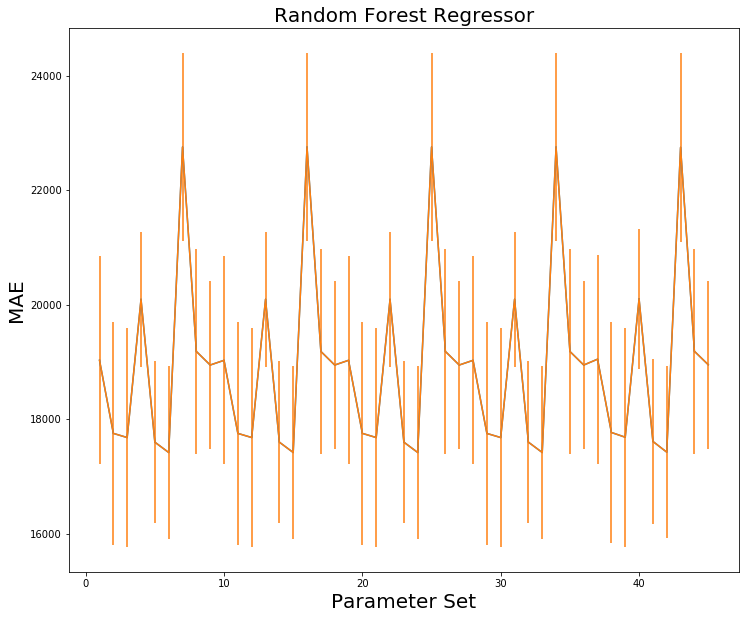

In [7]:
iterations = 45
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(rf_model, iterations)

plt.figure(figsize=(12,10))
plt.title('Random Forest Regressor', fontsize= 20)
plt.plot((np.arange(iterations)+1), mean_vec)
plt.errorbar((np.arange(iterations)+1), mean_vec, yerr = std_vec)
plt.ylabel("MAE", fontsize= 20)
plt.xlabel("Parameter Set", fontsize= 20)
#plt.ylim(14000, 40000)
plt.show()

In [8]:
#print vals
rf_results = pd.DataFrame(rf_model.cv_results_)
rf_results = rf_results[['params','mean_test_score','std_test_score', 'rank_test_score']]
rf_results = rf_results.sort_values(by=['rank_test_score'])
rf_results.head(10)

,params,mean_test_score,std_test_score,rank_test_score
14,"{'ccp_alpha': 0.01, 'max_features': 'sqrt', 'n...",-17421.763213,1502.939487,1
5,"{'ccp_alpha': 0.001, 'max_features': 'sqrt', '...",-17421.763240,1502.939490,2
23,"{'ccp_alpha': 0.1, 'max_features': 'sqrt', 'n_...",-17421.763949,1502.942714,3
32,"{'ccp_alpha': 1, 'max_features': 'sqrt', 'n_es...",-17421.901900,1503.060642,4
41,"{'ccp_alpha': 10, 'max_features': 'sqrt', 'n_e...",-17427.597955,1507.524377,5
22,"{'ccp_alpha': 0.1, 'max_features': 'sqrt', 'n_...",-17602.139018,1415.544461,6
4,"{'ccp_alpha': 0.001, 'max_features': 'sqrt', '...",-17602.139327,1415.537915,7
13,"{'ccp_alpha': 0.01, 'max_features': 'sqrt', 'n...",-17602.139396,1415.537811,8
31,"{'ccp_alpha': 1, 'max_features': 'sqrt', 'n_es...",-17602.234965,1415.786118,9
40,"{'ccp_alpha': 10, 'max_features': 'sqrt', 'n_e...",-17615.119472,1436.706236,10


In [9]:
# Test set valuation
rf_best = RandomForestRegressor(**rf_model.best_params_, n_jobs=-1, random_state=0, criterion = 'mae')
print('Best RandomForest parameters: ', rf_model.best_params_)

rf_best.fit(X, y)
y_pred = rf_best.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))

Best RandomForest parameters:  {'ccp_alpha': 0.01, 'max_features': 'sqrt', 'n_estimators': 500}
MAE : 17715.422263698634


# XGBoost

In [10]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=-1, objective='reg:squarederror', n_estimators = 100)

In [11]:
param_grid = {'max_depth': [2,4,6],
              'booster': ('gbtree', 'gblinear', 'dart'),
              'gamma': [0.01, 0.1, 1]
             }

xgb_model = GridSearchCV(xgb, param_grid, cv = 5, scoring = 'neg_mean_absolute_error', verbose = 4)
xgb_model.fit(X, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END booster=gbtree, gamma=0.01, max_depth=2;, score=-17442.920 total time=   3.4s
[CV 2/5] END booster=gbtree, gamma=0.01, max_depth=2;, score=-19397.118 total time=   2.4s
[CV 3/5] END booster=gbtree, gamma=0.01, max_depth=2;, score=-17947.463 total time=   2.4s
[CV 4/5] END booster=gbtree, gamma=0.01, max_depth=2;, score=-17990.649 total time=   2.4s
[CV 5/5] END booster=gbtree, gamma=0.01, max_depth=2;, score=-14633.408 total time=   2.6s
[CV 1/5] END booster=gbtree, gamma=0.01, max_depth=4;, score=-16469.609 total time=   5.1s
[CV 2/5] END booster=gbtree, gamma=0.01, max_depth=4;, score=-19608.521 total time=   1.3s
[CV 3/5] END booster=gbtree, gamma=0.01, max_depth=4;, score=-16991.243 total time=   0.4s
[CV 4/5] END booster=gbtree, gamma=0.01, max_depth=4;, score=-19156.619 total time=   0.3s
[CV 5/5] END booster=gbtree, gamma=0.01, max_depth=4;, score=-14261.448 total time=   0.4s
[CV 1/5] END booster=gbtree,

[CV 5/5] END booster=gblinear, gamma=0.01, max_depth=4;, score=-18820.899 total time=   0.2s
[17:13:35] WARNING: ../src/learner.cc:573: 
Parameters: { "gamma", "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/5] END booster=gblinear, gamma=0.01, max_depth=6;, score=-19322.094 total time=   0.2s
[17:13:35] WARNING: ../src/learner.cc:573: 
Parameters: { "gamma", "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/5] END booster=gblinear, gamma=0.01, max_depth=6;, score=-25140.315 total time=   0.4s
[17:13:35] WARNING: ../src/learner.cc:573

[CV 4/5] END booster=gblinear, gamma=0.1, max_depth=6;, score=-22937.738 total time=   0.2s
[17:13:40] WARNING: ../src/learner.cc:573: 
Parameters: { "gamma", "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 5/5] END booster=gblinear, gamma=0.1, max_depth=6;, score=-18762.836 total time=   0.4s
[17:13:40] WARNING: ../src/learner.cc:573: 
Parameters: { "gamma", "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/5] END booster=gblinear, gamma=1, max_depth=2;, score=-19296.730 total time=   0.2s
[17:13:40] WARNING: ../src/learner.cc:573: 
Pa

[CV 5/5] END booster=dart, gamma=0.01, max_depth=6;, score=-15887.743 total time=   3.3s
[CV 1/5] END booster=dart, gamma=0.1, max_depth=2;, score=-17442.920 total time=   2.8s
[CV 2/5] END booster=dart, gamma=0.1, max_depth=2;, score=-19397.118 total time=   3.0s
[CV 3/5] END booster=dart, gamma=0.1, max_depth=2;, score=-17947.463 total time=   2.3s
[CV 4/5] END booster=dart, gamma=0.1, max_depth=2;, score=-17990.649 total time=   2.8s
[CV 5/5] END booster=dart, gamma=0.1, max_depth=2;, score=-14633.408 total time=   3.0s
[CV 1/5] END booster=dart, gamma=0.1, max_depth=4;, score=-16469.609 total time=   3.5s
[CV 2/5] END booster=dart, gamma=0.1, max_depth=4;, score=-19608.521 total time=   2.8s
[CV 3/5] END booster=dart, gamma=0.1, max_depth=4;, score=-16991.243 total time=   3.4s
[CV 4/5] END booster=dart, gamma=0.1, max_depth=4;, score=-19156.619 total time=   3.3s
[CV 5/5] END booster=dart, gamma=0.1, max_depth=4;, score=-14261.448 total time=   3.2s
[CV 1/5] END booster=dart, gamm

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

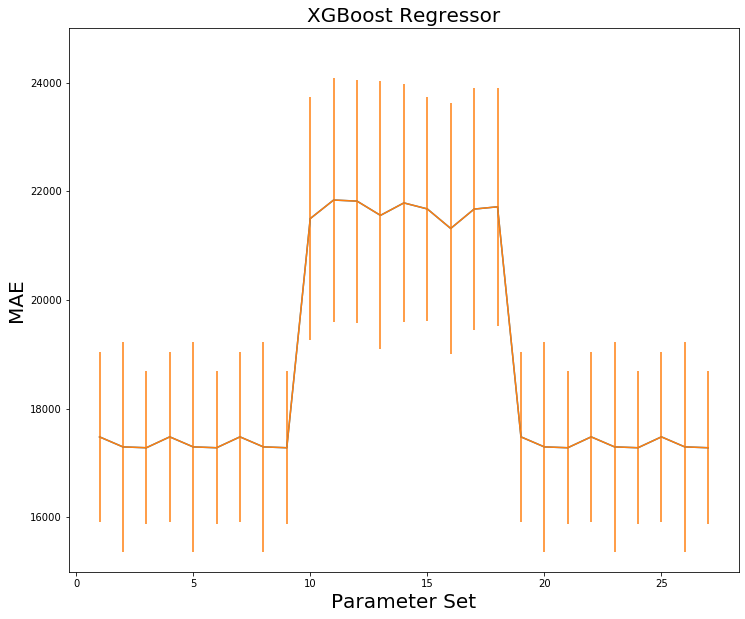

In [12]:
iterations = 27
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(xgb_model, iterations)

plt.figure(figsize=(12,10))
plt.title('XGBoost Regressor', fontsize= 20)
plt.plot((np.arange(iterations)+1), mean_vec)
plt.errorbar((np.arange(iterations)+1), mean_vec, yerr = std_vec)
plt.ylabel("MAE", fontsize= 20)
plt.xlabel("Parameter Set", fontsize= 20)
plt.ylim(15000, 25000)
plt.show()

In [13]:
#print vals
xgb_results = pd.DataFrame(xgb_model.cv_results_)
xgb_results = xgb_results[['params','mean_test_score','std_test_score', 'rank_test_score']]
xgb_results = xgb_results.sort_values(by=['rank_test_score'])
xgb_results.head(15)

,params,mean_test_score,std_test_score,rank_test_score
26,"{'booster': 'dart', 'gamma': 1, 'max_depth': 6}",-17282.112127,1404.543410,1
2,"{'booster': 'gbtree', 'gamma': 0.01, 'max_dept...",-17282.112127,1404.543410,1
5,"{'booster': 'gbtree', 'gamma': 0.1, 'max_depth...",-17282.112127,1404.543410,1
23,"{'booster': 'dart', 'gamma': 0.1, 'max_depth': 6}",-17282.112127,1404.543410,1
8,"{'booster': 'gbtree', 'gamma': 1, 'max_depth': 6}",-17282.112127,1404.543410,1
20,"{'booster': 'dart', 'gamma': 0.01, 'max_depth'...",-17282.112127,1404.543410,1
1,"{'booster': 'gbtree', 'gamma': 0.01, 'max_dept...",-17297.488138,1938.759744,7
4,"{'booster': 'gbtree', 'gamma': 0.1, 'max_depth...",-17297.488138,1938.759744,7
7,"{'booster': 'gbtree', 'gamma': 1, 'max_depth': 4}",-17297.488138,1938.759744,7
22,"{'booster': 'dart', 'gamma': 0.1, 'max_depth': 4}",-17297.488138,1938.759744,7


In [14]:
# Test set valuation
xgb_best = XGBRegressor(**xgb_model.best_params_, n_jobs=-1, objective='reg:squarederror', n_estimators = 100)
print('Best XGBoost parameters: ', xgb_model.best_params_)

xgb_best.fit(X, y)
y_pred = xgb_best.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))

Best XGBoost parameters:  {'booster': 'gbtree', 'gamma': 0.01, 'max_depth': 6}
MAE : 17771.743204195205


# LightGBM

In [15]:
import lightgbm
lgb = lightgbm.LGBMRegressor()

In [16]:
param_grid = {'num_leaves': [5,15,31],
              'boosting_type': ('gbdt', 'dart', 'gross'),
              'reg_alpha': [0.01, 0.1, 1]
             }

lgb_model = GridSearchCV(lgb, param_grid, cv = 5, scoring = 'neg_mean_absolute_error', verbose = 4)
lgb_model.fit(X, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.01;, score=-15375.534 total time=   0.4s
[CV 2/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.01;, score=-17597.849 total time=   0.1s
[CV 3/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.01;, score=-17237.979 total time=   0.1s
[CV 4/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.01;, score=-17935.397 total time=   0.1s
[CV 5/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.01;, score=-13444.873 total time=   0.1s
[CV 1/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.1;, score=-15375.534 total time=   0.1s
[CV 2/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.1;, score=-17597.849 total time=   0.1s
[CV 3/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.1;, score=-17237.979 total time=   0.1s
[CV 4/5] END boosting_type=gbdt, num_leaves=5, reg_alpha=0.1;, score=-17935.397 total time=   0.9s
[CV 5/5] END boosting_type=gbdt, num_leave

[CV 3/5] END boosting_type=dart, num_leaves=31, reg_alpha=0.1;, score=-25922.323 total time=   0.5s
[CV 4/5] END boosting_type=dart, num_leaves=31, reg_alpha=0.1;, score=-24598.874 total time=   0.4s
[CV 5/5] END boosting_type=dart, num_leaves=31, reg_alpha=0.1;, score=-19868.226 total time=   0.7s
[CV 1/5] END boosting_type=dart, num_leaves=31, reg_alpha=1;, score=-21082.855 total time=   0.3s
[CV 2/5] END boosting_type=dart, num_leaves=31, reg_alpha=1;, score=-24850.935 total time=   0.3s
[CV 3/5] END boosting_type=dart, num_leaves=31, reg_alpha=1;, score=-25922.342 total time=   0.4s
[CV 4/5] END boosting_type=dart, num_leaves=31, reg_alpha=1;, score=-24595.870 total time=   0.3s
[CV 5/5] END boosting_type=dart, num_leaves=31, reg_alpha=1;, score=-19887.503 total time=   0.3s
[CV 1/5] END boosting_type=gross, num_leaves=5, reg_alpha=0.01;, score=nan total time=   0.0s
[CV 2/5] END boosting_type=gross, num_leaves=5, reg_alpha=0.01;, score=nan total time=   0.0s
[CV 3/5] END boosting_

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'boosting_type': ('gbdt', 'dart', 'gross'),
                         'num_leaves': [5, 15, 31],
                         'reg_alpha': [0.01, 0.1, 1]},
             scoring='neg_mean_absolute_error', verbose=4)

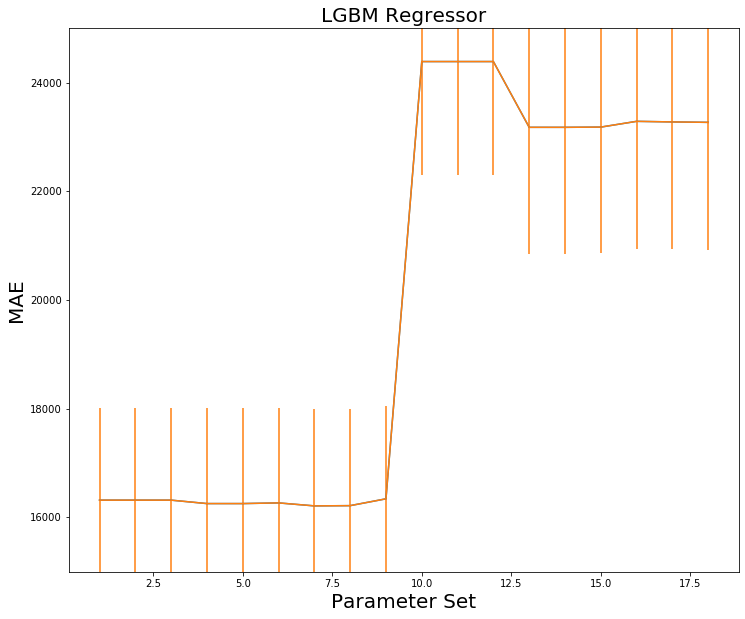

In [17]:
iterations = 27
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(lgb_model, iterations)

plt.figure(figsize=(12,10))
plt.title('LGBM Regressor', fontsize= 20)
plt.plot((np.arange(iterations)+1), mean_vec)
plt.errorbar((np.arange(iterations)+1), mean_vec, yerr = std_vec)
plt.ylabel("MAE", fontsize= 20)
plt.xlabel("Parameter Set", fontsize= 20)
plt.ylim(15000, 25000)
plt.show()

In [18]:
#print vals
lgb_results = pd.DataFrame(lgb_model.cv_results_)
lgb_results = lgb_results[['params','mean_test_score','std_test_score', 'rank_test_score']]
lgb_results = lgb_results.sort_values(by=['rank_test_score'])
lgb_results.head(15)

,params,mean_test_score,std_test_score,rank_test_score
6,"{'boosting_type': 'gbdt', 'num_leaves': 31, 'r...",-16212.575673,1788.358670,1
7,"{'boosting_type': 'gbdt', 'num_leaves': 31, 'r...",-16217.093093,1773.566965,2
4,"{'boosting_type': 'gbdt', 'num_leaves': 15, 'r...",-16255.099725,1760.728873,3
3,"{'boosting_type': 'gbdt', 'num_leaves': 15, 'r...",-16255.099928,1760.728752,4
5,"{'boosting_type': 'gbdt', 'num_leaves': 15, 'r...",-16267.440067,1748.201297,5
0,"{'boosting_type': 'gbdt', 'num_leaves': 5, 're...",-16318.326482,1687.806185,6
1,"{'boosting_type': 'gbdt', 'num_leaves': 5, 're...",-16318.326518,1687.806287,7
2,"{'boosting_type': 'gbdt', 'num_leaves': 5, 're...",-16318.326873,1687.807292,8
8,"{'boosting_type': 'gbdt', 'num_leaves': 31, 'r...",-16342.575839,1706.844336,9
13,"{'boosting_type': 'dart', 'num_leaves': 15, 'r...",-23176.397023,2337.365526,10


In [19]:
# Test set valuation
lgb_best = lightgbm.LGBMRegressor(**lgb_model.best_params_)
print('Best LightGBM parameters: ', lgb_model.best_params_)

lgb_best.fit(X, y)
y_pred = lgb_best.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))

Best LightGBM parameters:  {'boosting_type': 'gbdt', 'num_leaves': 31, 'reg_alpha': 0.01}
MAE : 16772.87610287696


# Stacking

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
Ridge_2 = make_pipeline(PolynomialFeatures(degree=2), Ridge(normalize=True, random_state=0))

In [111]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

estimators = [
    ('ridge', Ridge_2),
    ('xgb', XGBRegressor(**xgb_model.best_params_, random_state = 0)),
    ('lgb', lightgbm.LGBMRegressor(**lgb_model.best_params_, random_state = 0))]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(**rf_model.best_params_, n_jobs=-1, random_state=0, criterion = 'mae'),
)

In [112]:
stack.fit(X, y)

StackingRegressor(estimators=[('ridge',
                               Pipeline(steps=[('polynomialfeatures',
                                                PolynomialFeatures()),
                                               ('ridge',
                                                Ridge(normalize=True,
                                                      random_state=0))])),
                              ('xgb',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0.01,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learni...
                                            num_parallel_tree=None,
         

# Model Evaluation

In [23]:
from sklearn.model_selection import cross_validate
scores = cross_validate(stack, X, y, cv=5,
                        scoring=('r2', 'neg_mean_absolute_error'),
                        return_train_score=False)

In [24]:
scores['test_neg_mean_absolute_error']

array([-13824.75010256, -17372.35339316, -16507.67949573, -17355.05616309,
       -14209.94360515])

In [25]:
scores['test_neg_mean_absolute_error'].mean()

-15853.956551938667

In [26]:
variance = sum([((x - scores['test_neg_mean_absolute_error'].mean()) ** 2) for x in scores['test_neg_mean_absolute_error']]) / len(scores)
variance ** 0.5

1718.0395863209365

## Results on test set

In [80]:
y_pred = stack.predict(X_test)

In [81]:
print("MAE :", mean_absolute_error(y_test, y_pred))

MAE : 16363.711592465754


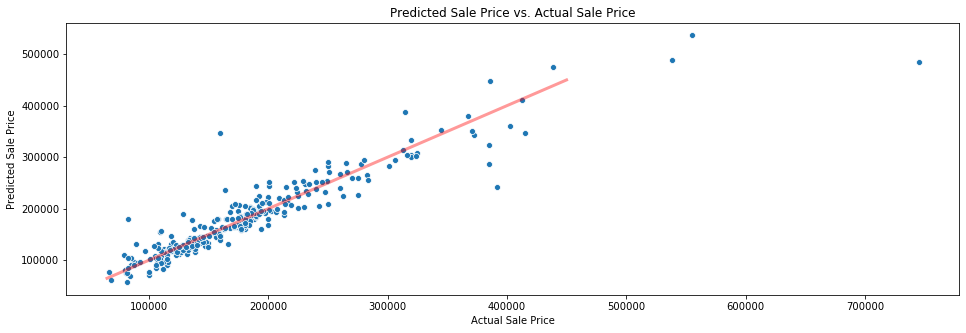

In [82]:
plt.figure(figsize=(16,5))
plot = sns.scatterplot(x=y_test, y=y_pred)
plot.set(xlabel='Actual Sale Price', ylabel='Predicted Sale Price')
plot.set_title('Predicted Sale Price vs. Actual Sale Price')
plt.plot(np.array([65000.,450000.]), np.array([65000.,450000.]), color='red', alpha=0.4, linewidth=3)
plt.show()

## Tax Regressivity Analysis

In [113]:
y_train_pred = stack.predict(X)

In [114]:
pred_train = pd.DataFrame(y_train_pred, y).reset_index()
pred_test = pd.DataFrame(y_pred, y_test).reset_index()
predictions = pd.concat([pred_train, pred_test]).rename(columns={'SalePrice': "Original_Price", 0: "Predicted_Price"})

In [115]:
predictions['Assessment'] = np.where(predictions['Predicted_Price']>predictions['Original_Price'], 'Overvalued', 'Undervalued')

predictions = predictions.reset_index().drop(columns = 'index')

predictions['Sale Decile'] = (predictions.index//146) +1

In [116]:
predictions['Percentage_Difference'] = abs(predictions['Predicted_Price'] - predictions['Original_Price'])/predictions['Original_Price']*100
predictions = predictions.sort_values(by = 'Original_Price')

In [117]:
predictions

,Original_Price,Predicted_Price,Assessment,Sale Decile,Percentage_Difference
350,34900,45412.126000,Overvalued,3,30.120705
573,35311,45412.126000,Overvalued,4,28.606174
629,37900,45412.126000,Overvalued,5,19.820913
256,39300,45412.126000,Overvalued,2,15.552483
329,40000,45412.126000,Overvalued,3,13.530315
901,52000,43334.316000,Undervalued,7,16.664777
83,52500,41773.130000,Undervalued,1,20.432133
807,55000,42182.778000,Undervalued,6,23.304040
1154,55000,42795.544000,Undervalued,8,22.189920
976,55993,55599.864000,Undervalued,7,0.702116


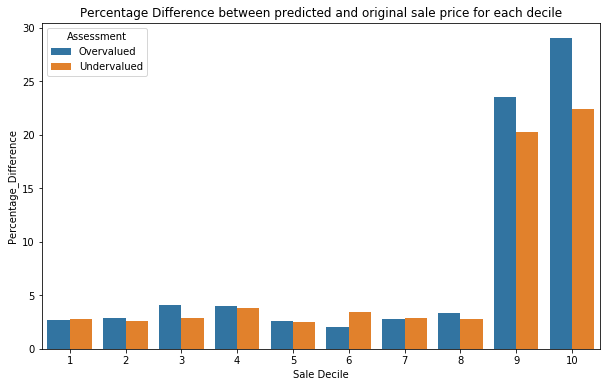

In [118]:
import seaborn as sns
fig, ax = plt.subplots(figsize= (10,6))
ax = sns.barplot(x="Sale Decile", y="Percentage_Difference", hue="Assessment", data=predictions, ci=None)\
.set_title('Percentage Difference between predicted and original sale price for each decile')

## Fairness Plots

In [38]:
def fairness(model):
    model.fit(X, y)
    y_train_pred = model.predict(X)
    pred_train = pd.DataFrame(y_train_pred, y).reset_index()
    pred_test = pd.DataFrame(y_pred, y_test).reset_index()
    predictions = pd.concat([pred_train, pred_test]).rename(columns={'SalePrice': "Original_Price", 0: "Predicted_Price"})
    predictions['Assessment'] = np.where(predictions['Predicted_Price']>predictions['Original_Price'], 'Overvalued', 'Undervalued')
    predictions = predictions.reset_index().drop(columns = 'index')
    predictions['Sale_Category'] = np.where(predictions['Original_Price'] > 174000, 'Medium-Priced Home', 'Low-Priced Home')
    predictions['Sale_Category'] = np.where(predictions['Original_Price'] > 293077, 'High-Priced Home', predictions['Sale_Category'])
    predictions_group = predictions.groupby(['Sale_Category', 'Assessment']).count()
    predictions_group = predictions_group.reset_index()
    predictions_group['Category_Total'] = predictions['Sale_Category'].value_counts()[predictions_group['Sale_Category']]\
    .reset_index().rename(columns={'Sale_Category':'Total','index': 'Sale_Category'})['Total']
    predictions_group['Percentage'] = predictions_group['Original_Price']/predictions_group['Category_Total']
    return predictions_group

In [39]:
df = fairness(stack)
df = df.sort_values(['Category_Total', 'Assessment'], ascending = False)

(0, 1)

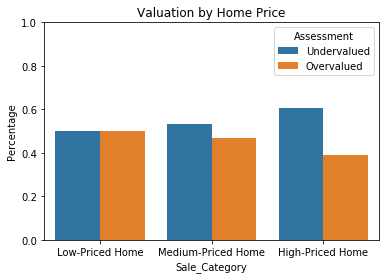

In [58]:
plt.subplots(figsize= (6,4))
plot = sns.barplot(x="Sale_Category", y="Percentage", hue="Assessment", data=df, ci=None)\
.set_title("Valuation by Home Price")
plt.ylim(0, 1)

In [67]:
df = fairness(rf_best)
df = df.sort_values(['Category_Total','Assessment'], ascending = False)

(0, 1)

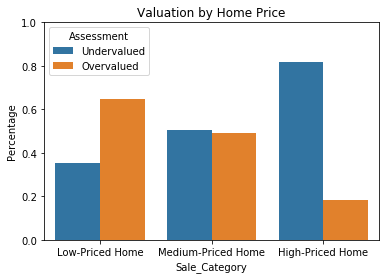

In [69]:
plt.subplots(figsize= (6,4))
plot = sns.barplot(x="Sale_Category", y="Percentage", hue="Assessment", data=df, ci=None)\
.set_title("Valuation by Home Price")
plt.ylim(0, 1)

In [72]:
df = fairness(xgb_best)
df = df.sort_values(['Category_Total', 'Assessment'], ascending = False)

(0, 1)

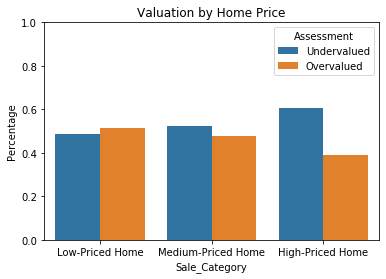

In [74]:
plt.subplots(figsize= (6,4))
plot = sns.barplot(x="Sale_Category", y="Percentage", hue="Assessment", data=df, ci=None)\
.set_title("Valuation by Home Price")
plt.ylim(0, 1)

In [75]:
df = fairness(lgb_best)
df = df.sort_values(['Category_Total', 'Assessment'], ascending = False)

(0, 1)

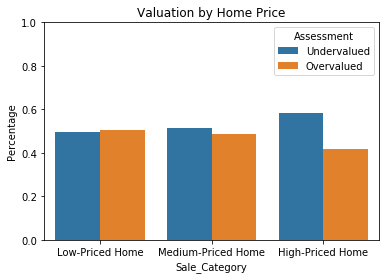

In [76]:
plt.subplots(figsize= (6,4))
plot = sns.barplot(x="Sale_Category", y="Percentage", hue="Assessment", data=df, ci=None)\
.set_title("Valuation by Home Price")
plt.ylim(0, 1)

In [96]:
df = fairness(svr_best)
df = df.sort_values(['Category_Total', 'Assessment'], ascending = False)

(0, 1)

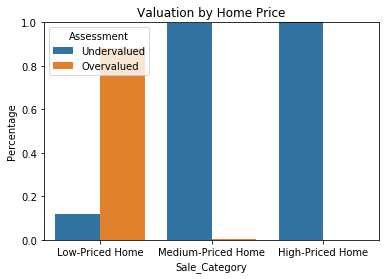

In [97]:
plt.subplots(figsize= (6,4))
plot = sns.barplot(x="Sale_Category", y="Percentage", hue="Assessment", data=df, ci=None)\
.set_title("Valuation by Home Price")
plt.ylim(0, 1)